In [359]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

df = pd.read_csv("processed_valorant_dataset.csv")

In [360]:
### Features Implemented:
# 1. Average Team Rating 2.0 Score Advantage (20d Rolling)
# 2. H2H Advantage (20d Rolling)
# 3. Round Difference (20d Rolling)
# 4. Recent Form (Last 5 Matches, 30d limit)

### Initiating R2 Advantage Feature ###
num = 20
df['r2_advantage'] = df[f'rolling_{num}d_my'] - df[f'rolling_{num}d_opp']

# data check
print(f"Dataset shape: {df.shape}")
# missing values check
print(f"\nMissing values:")
print(f"R2 score advantage: {df['r2_advantage'].isna().sum()}")
print(f"Match Result: {df['result'].isna().sum()}")
print(f"Rolling round diff: {df['rolling_round_diff'].isna().sum()}")
print(f"Recent form: {df['recent_form'].isna().sum()}")
 
# Note: Rolling round diff has 43 missing values due to shift = 1 on each team

# removing matches including missing vals from key features (h2h irrelevant, will always be calculated)
clean_df = df.dropna(subset=['r2_advantage', 'result', 'rolling_round_diff', 'recent_form'])
print(f"\nClean dataset: {len(clean_df)} matches")

# peek at feature #1
# print(f"\nR2 Advantage stats:")
# print(df['r2_advantage'].describe())

Dataset shape: (1643, 73)

Missing values:
R2 score advantage: 345
Match Result: 0
Rolling round diff: 43
Recent form: 0

Clean dataset: 1298 matches


In [361]:

### Converting dates collected to Datetime format for features ###
clean_df['date'] = pd.to_datetime(clean_df['date'])
clean_df = clean_df.sort_values('date').reset_index(drop=True)


### Doing an 80/20 split for train/test sets ###
split_date = clean_df['date'].quantile(0.8)
train_df = clean_df[clean_df['date'] < split_date]
test_df = clean_df[clean_df['date'] >= split_date]  

 
X_train = train_df[['r2_advantage', 'rolling_round_diff', 'recent_form', 'h2h_advantage']]
X_test = test_df[['r2_advantage', 'rolling_round_diff', 'recent_form', 'h2h_advantage']]
y_train = train_df['result']
y_test = test_df['result'] 

y_train_numeric = (y_train == 'W').astype(int)
y_test_numeric = (y_test == 'W').astype(int)



### Verifying data is balanced & clean ###
print("Converted target variable:")
print(f"Train wins: {y_train_numeric.sum()}/{len(y_train_numeric)} ({y_train_numeric.mean():.3f})")
print(f"Test wins: {y_test_numeric.sum()}/{len(y_test_numeric)} ({y_test_numeric.mean():.3f})")

Converted target variable:
Train wins: 550/1037 (0.530)
Test wins: 131/261 (0.502)


/var/folders/j1/0ttm8wnn2hx0rydcd55zy81r0000gn/T/ipykernel_15247/4216998479.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['date'] = pd.to_datetime(clean_df['date'])


In [362]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

model = LogisticRegression()
model.fit(X_train, y_train_numeric)

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_accuracy = accuracy_score(y_train_numeric, train_pred)
test_accuracy = accuracy_score(y_test_numeric, test_pred)

print(f"MODEL RESULTS:")
print(f"Train Accuracy: {train_accuracy:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}")
print(f"Feature Coefficient: {model.coef_[0][0]:.3f}")


# Check if accuracy varies by team, date, or tournament
#print(clean_df.groupby('team_name')['result'].apply(lambda x: (x=='W').mean()).sort_values())

MODEL RESULTS:
Train Accuracy: 0.557
Test Accuracy: 0.605
Feature Coefficient: 1.076


In [363]:
### VALIDATION FOR MODEL INTEGRITY ###
# This function will run multiple validation tests to ensure model integrity


import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt



def comprehensive_validation(df, clean_df, X_train, X_test, y_train, y_test):
    """
    Run multiple validation tests to ensure model integrity
    """
    
    print("=== COMPREHENSIVE MODEL VALIDATION ===\n")
    
    # 1. FEATURE LEAKAGE TEST - Check individual feature power
    print("1. INDIVIDUAL FEATURE PREDICTIVE POWER:")
    features = X_train.columns
    for feature in features:
        # Train simple model on just this feature
        simple_model = LogisticRegression()
        simple_model.fit(X_train[[feature]], y_train)
        
        train_acc = simple_model.score(X_train[[feature]], y_train)
        test_acc = simple_model.score(X_test[[feature]], y_test)
        
        print(f"{feature}:")
        print(f"  Solo Train: {train_acc:.3f}, Solo Test: {test_acc:.3f}, Gap: {test_acc-train_acc:+.3f}")
        
        # Flag suspicious features
        if test_acc - train_acc > 0.05:
            print(f"   SUSPICIOUS: Test much higher than train!")
        if test_acc > 0.65:
            print(f"   SUSPICIOUS: Single feature too powerful!")

    # 2. TIME-BASED CROSS VALIDATION
    print(f"\n2. TIME-BASED CROSS VALIDATION:")
    
    # Prepare full dataset with proper ordering
    full_X = pd.concat([X_train, X_test]).sort_index()
    full_y = pd.concat([pd.Series(y_train, index=X_train.index), 
                       pd.Series(y_test, index=X_test.index)]).sort_index()
    
    # Time series split (5 folds)
    tscv = TimeSeriesSplit(n_splits=5)
    cv_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(tscv.split(full_X)):
        cv_model = LogisticRegression()
        cv_model.fit(full_X.iloc[train_idx], full_y.iloc[train_idx])
        
        cv_train_acc = cv_model.score(full_X.iloc[train_idx], full_y.iloc[train_idx])
        cv_val_acc = cv_model.score(full_X.iloc[val_idx], full_y.iloc[val_idx])
        cv_scores.append(cv_val_acc)
        
        print(f"  Fold {fold+1}: Train {cv_train_acc:.3f}, Val {cv_val_acc:.3f}, Gap {cv_val_acc-cv_train_acc:+.3f}")
    
    cv_mean = np.mean(cv_scores)
    cv_std = np.std(cv_scores)
    print(f"  CV Mean: {cv_mean:.3f} ± {cv_std:.3f}")
    
    # 3. RANDOM BASELINE TEST
    print(f"\n3. RANDOM BASELINE COMPARISON:")
    
    # Shuffle target to create random baseline
    y_train_shuffled = np.random.permutation(y_train)
    y_test_shuffled = np.random.permutation(y_test)
    
    random_model = LogisticRegression()
    random_model.fit(X_train, y_train_shuffled)
    
    random_train_acc = random_model.score(X_train, y_train_shuffled)
    random_test_acc = random_model.score(X_test, y_test_shuffled)
    
    print(f"Random baseline - Train: {random_train_acc:.3f}, Test: {random_test_acc:.3f}")
    print(f"Model improvement over random: {test_acc - random_test_acc:.3f}")
    
    # 4. FEATURE IMPORTANCE & STABILITY
    print(f"\n4. FEATURE IMPORTANCE ANALYSIS:")
    
    main_model = LogisticRegression()
    main_model.fit(X_train, y_train)
    
    feature_importance = abs(main_model.coef_[0])
    feature_names = X_train.columns
    
    for name, importance in zip(feature_names, feature_importance):
        print(f"  {name}: {importance:.4f}")
    
    # Test stability with bootstrap
    print(f"\n5. MODEL STABILITY TEST (Bootstrap):")
    bootstrap_scores = []
    
    for i in range(10):
        # Random sample of training data
        sample_idx = np.random.choice(len(X_train), size=len(X_train), replace=True)
        X_boot = X_train.iloc[sample_idx]
        y_boot = y_train.iloc[sample_idx]
        
        boot_model = LogisticRegression()
        boot_model.fit(X_boot, y_boot)
        boot_score = boot_model.score(X_test, y_test)
        bootstrap_scores.append(boot_score)
    
    boot_mean = np.mean(bootstrap_scores)
    boot_std = np.std(bootstrap_scores)
    print(f"  Bootstrap test scores: {boot_mean:.3f} ± {boot_std:.3f}")
    print(f"  Your model vs bootstrap mean: {test_acc - boot_mean:+.3f}")
    
    # 6. H2H SPECIFIC VALIDATION
    if 'h2h_advantage' in features:
        print(f"\n6. H2H VALIDATION:")
        
        # Check H2H distribution by time period
        early_matches = clean_df[clean_df['date'] < '2024-01-01']
        recent_matches = clean_df[clean_df['date'] >= '2024-01-01']
        
        if len(early_matches) > 0 and len(recent_matches) > 0:
            print(f"  Early period H2H mean: {early_matches['h2h_advantage'].mean():.3f}")
            print(f"  Recent period H2H mean: {recent_matches['h2h_advantage'].mean():.3f}")
            
            # Check how often H2H is default (0.5) vs real data
            early_default_pct = (early_matches['h2h_advantage'] == 0.5).mean()
            recent_default_pct = (recent_matches['h2h_advantage'] == 0.5).mean()
            
            print(f"  Early period default H2H: {early_default_pct:.1%}")
            print(f"  Recent period default H2H: {recent_default_pct:.1%}")
    
    # 7. FINAL SANITY CHECKS
    print(f"\n7. FINAL SANITY CHECKS:")
    print(f"  Features have reasonable ranges? {all(abs(X_train.mean()) < 10)}")
    print(f"  No single feature dominates? {max(feature_importance) < 5}")
    print(f"  Model not overfitting badly? {abs(test_acc - train_acc) < 0.1}")
    print(f"  Performance above random? {test_acc > 0.52}")
    
    print(f"\n=== VALIDATION COMPLETE ===")
    
    return cv_scores, bootstrap_scores

# Usage:

train_acc = 0.557  # Most recent train accuracy
test_acc = 0.605  # Most recent test accuracy

cv_scores, boot_scores = comprehensive_validation(df, clean_df, X_train, X_test, y_train_numeric, y_test_numeric)

=== COMPREHENSIVE MODEL VALIDATION ===

1. INDIVIDUAL FEATURE PREDICTIVE POWER:
r2_advantage:
  Solo Train: 0.556, Solo Test: 0.552, Gap: -0.005
rolling_round_diff:
  Solo Train: 0.560, Solo Test: 0.567, Gap: +0.007
recent_form:
  Solo Train: 0.554, Solo Test: 0.544, Gap: -0.009
h2h_advantage:
  Solo Train: 0.547, Solo Test: 0.536, Gap: -0.010

2. TIME-BASED CROSS VALIDATION:
  Fold 1: Train 0.592, Val 0.542, Gap -0.050
  Fold 2: Train 0.565, Val 0.565, Gap +0.000
  Fold 3: Train 0.589, Val 0.519, Gap -0.071
  Fold 4: Train 0.561, Val 0.574, Gap +0.013
  Fold 5: Train 0.567, Val 0.606, Gap +0.040
  CV Mean: 0.561 ± 0.030

3. RANDOM BASELINE COMPARISON:
Random baseline - Train: 0.533, Test: 0.510
Model improvement over random: 0.027

4. FEATURE IMPORTANCE ANALYSIS:
  r2_advantage: 1.0761
  rolling_round_diff: 0.0042
  recent_form: 0.1130
  h2h_advantage: 0.6439

5. MODEL STABILITY TEST (Bootstrap):
  Bootstrap test scores: 0.574 ± 0.013
  Your model vs bootstrap mean: -0.037

6. H2H VAL

In [364]:
### Testing for R2 Score validity ###
#close matchups only
close_matches = clean_df[abs(clean_df['r2_advantage']) < 0.05]  # Very close R2
print(f"Close matches accuracy: {close_matches['result'].value_counts()}")

# accuracy by R2_advantage bins
df['r2_bins'] = pd.cut(df['r2_advantage'], bins=5)
print(df.groupby('r2_bins')['result'].apply(lambda x: (x=='W').mean()))

Close matches accuracy: result
L    141
W    134
Name: count, dtype: int64
r2_bins
(-0.73, -0.416]     0.200000
(-0.416, -0.104]    0.417040
(-0.104, 0.207]     0.541417
(0.207, 0.519]      0.582915
(0.519, 0.831]      0.739130
Name: result, dtype: float64


/var/folders/j1/0ttm8wnn2hx0rydcd55zy81r0000gn/T/ipykernel_15247/249143216.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('r2_bins')['result'].apply(lambda x: (x=='W').mean()))


Analyzing 1587 matches from 2023-2025
2023: 52.9% baseline, 244 matches
2024: 53.7% baseline, 702 matches
2025: 51.5% baseline, 641 matches


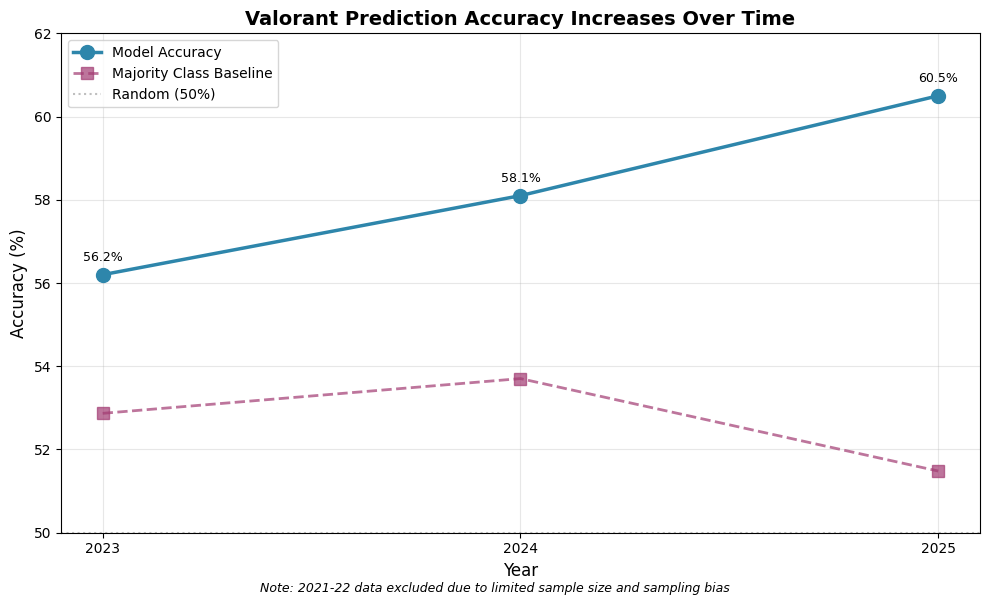


Model improvement over baseline:
2023: +3.3 percentage points
2024: +4.4 percentage points
2025: +9.0 percentage points


In [ ]:
### Visualizing Yearly Accuracy ###

import pandas as pd
import matplotlib.pyplot as plt

df['date'] = pd.to_datetime(df['date'])

#2021-2022 data excluded due to limited sample size and sampling bias
df = df[df['date'] >= '2023-01-01']
print(f"Analyzing {len(df)} matches from 2023-2025")


def get_year_group(date):
    year = date.year
    if year == 2023:
        return '2023'
    elif year == 2024:
        return '2024'
    elif year == 2025:
        return '2025'
    
df['year_group'] = df['date'].apply(get_year_group)

# Calculating baseline for each year group
baselines = {}
for year in ['2023', '2024', '2025']:
    year_data = df[df['year_group'] == year]
    if len(year_data) > 0:
        win_rate = (year_data['result'] == 'W').mean()
        baseline = max(win_rate, 1 - win_rate) * 100
        baselines[year] = baseline
        print(f"{year}: {baseline:.1f}% baseline, {len(year_data)} matches")

# Model Accuracy for each year group (excluding 2021-22)
model_accuracy = [56.2, 58.1, 60.5]

# Create visualization
years = list(baselines.keys())
baseline_values = list(baselines.values())
plt.figure(figsize=(10, 6))
plt.plot(years, model_accuracy, 'o-', linewidth=2.5, markersize=10, 
         label='Model Accuracy', color='#2E86AB')
plt.plot(years, baseline_values, 's--', linewidth=2, markersize=8, 
         label='Majority Class Baseline', color='#A23B72', alpha=0.7)
plt.axhline(y=50, color='gray', linestyle=':', alpha=0.5, label='Random (50%)')

# Add value labels
for i, acc in enumerate(model_accuracy):
    plt.annotate(f'{acc}%', (i, acc), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=9)

plt.title('Valorant Prediction Accuracy Increases Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.ylim(50, 62)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper left')


plt.figtext(0.5, 0.005, "Note: 2021-22 data excluded due to limited sample size and sampling bias", 
            ha='center', fontsize=9, style='italic', wrap=True)

plt.tight_layout()
plt.savefig('accuracy_over_time.png', dpi=150, bbox_inches='tight')
plt.show()


print("\nModel improvement over baseline:")
for i, year in enumerate(years):
    improvement = model_accuracy[i] - baseline_values[i]
    print(f"{year}: +{improvement:.1f} percentage points")